## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np

import virl

## Simulation: Single Choice

In [4]:
env = virl.Epidemic(stochastic=False, noisy=False)
"""
Args:
    stochastic (bool): Is the infection rate sampled from some distribution at the beginning of each episode (default: False)?
    noisy (bool): Is the state a noisy estimate of the true state (default: False)?
    problem_id (int): Deterministic parameterization of the epidemic (default: 0).
"""

all_states = []
all_rewards = []

for i in range(4):
    states = []
    rewards = []
    
    done = False
    s = env.reset()
    states.append(s)
    
    while not done:
        s, r, done, info = env.step(action=i) # deterministic agent
        states.append(s)
        rewards.append(r)
    
    all_states.append(states)
    all_rewards.append(rewards)

## Analysis: Single Choice

average reward 0: -0.03233051431950933
average reward 1: -0.031417197116765064
average reward 2: -0.02471104474530756
average reward 3: -0.029889663783994845


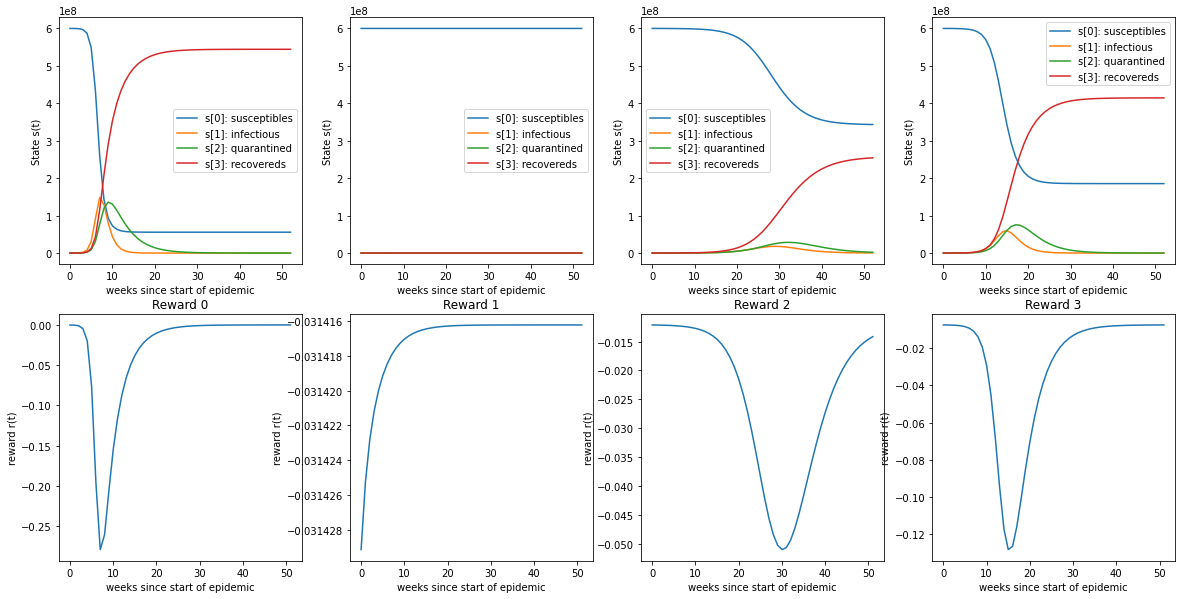

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']

for i in range(4):
    np_states = np.array(all_states[i])
    for j in range(4):
        axes[0,i].plot(np_states[:,j], label=labels[j]);
    axes[0,i].set_xlabel('weeks since start of epidemic')
    axes[0,i].set_ylabel('State s(t)')
    axes[0,i].legend()

    axes[1,i].plot(all_rewards[i]);
    axes[1,i].set_title('Reward ' + str(i))
    axes[1,i].set_xlabel('weeks since start of epidemic')
    axes[1,i].set_ylabel('reward r(t)')

    print('average reward ' + str(i) + ": " + str(sum(all_rewards[i])/len(all_rewards[i])))

# POLICY SEARCH AGENT
An AI agent that updates its policy model with each episode until it reaches optimization.

In [9]:
class PolicySearchAgent:
    '''
    Constructor requires an approximator to be defined outside of the Policy class. 
    ie, discretized state space or linear function approximator
    '''
    def __init__(self, approximator, gamma=1, episode_length=7):
        self.approximator = approximator
        self.episode_length = episode_length
        self.gamma = gamma # Discount factor
        self.states = []
        self.actions = []
        self.rewards = []
        self.steps = 0        
        self.__build_model()
        self.__build_train_fn()
     
    '''
    Private methods whose implementations will be defined by the approximator object
    '''
    def __build_model(self):
        self.model = self.approximator.build_model
        
    def __build_train_fn(self):
        self.train_fn = self.approximator.build_train_fn
        
    def __update_model(self, target):
        action_onehot = np_utils.to_categorical(self.actions, num_classes=4)
        self.train_fn([self.episode.states, action_onehot, target])
        return 
    
    '''
    Public methods to be used in epidemic simulation loop
    '''
    def predict(self, state, action=None):
        if a is None:            
            return self.model.predict(state)
        else:   
            return self.model.predict(state)[action]
    
    def increment(self, state, action, reward):
        # Increment steps and add latest state, action and reward to episode
        self.steps += 1
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
        # Update the policy model and reset everything
        if self.steps >= self.episode_length:
            for i in range(self.episode_length):
                target = sum(gamma**n * reward for n, reward in enumerate(self.rewards[i:]))
                self.__update_model(target)
            self.steps = 0
            self.states = []
            self.actions = []
            self.rewards = []

# APPROXIMATOR
To be completed for relevent approximation methods

In [10]:
# Base class to be implemented 
class Approximator():
    def build_model(self):
        raise NotImplementedError
        
    def build_train_fn(self):
        raise NotImplementedError

In [12]:
# Discrete state space implementation
class DSSApproximator(Approximator):
    def __init__(self, alpha=1):
        self.alpha = alpha
        
    def build_model(self):
        raise NotImplementedError
        
    def build_train_fn(self):
        raise NotImplementedError

# SIMULATION

In [ ]:
env = virl.Epidemic(stochastic=False, noisy=False)
"""
Args:
    stochastic (bool): Is the infection rate sampled from some distribution at the beginning of each episode (default: False)?
    noisy (bool): Is the state a noisy estimate of the true state (default: False)?
    problem_id (int): Deterministic parameterization of the epidemic (default: 0).
"""

states = []
rewards = []
done = False

s = env.reset()
states.append(s)

# Set up policy search agent
dss_approx = DSSApproximator()
ps_agent = PolicySearchAgent(dss_approx)

while not done:
    # Get policy to give set of action probs based on latest state and choose largest prob
    action_probs = ps_agent.predict(states[-1])
    choice = np.argmax(action_probs)
    
    # Make a step in environemnt
    s, r, done, i = env.step(action=choice) 
    states.append(s)
    rewards.append(r)
    
    # Update policy
    ps_agent.increment(s, s, choice, r)